In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from torch import nn

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [65]:
x_train = np.load('processed_notes.npy', allow_pickle=True)
y_train = np.load('processed_notes_labels.npy', allow_pickle=True)

x_val = np.load('processed_notes_val.npy', allow_pickle=True)
y_val = np.load('processed_notes_labels_val.npy', allow_pickle=True)

x_test = np.load('processed_notes_test.npy', allow_pickle=True)
y_test = np.load('processed_notes_labels_test.npy', allow_pickle=True)



In [5]:
len(x_train[0][0])

768

In [35]:
# notes is a list of list of embeddings corresponding to all notes for a batch of patients
# embed_size is the size of a note embedding for a single note. This is 768
# seq_len is the length we pad each note list to
# we want the final input size to be 
#   (batch_size, seq_len, embed_size)
def pad_input(notes, embed_size, seq_len=None):
    
    # if max sequence length not specified, use largest from data
    if seq_len == None:
        seq_len = max([len(x) for x in notes])
    
    # array starts out all zeros of the desired size
    padded = np.zeros((len(notes), seq_len, embed_size),dtype=float)
    # go through each note list
    for ii, review in enumerate(notes):
        # set the last n elements of padded to the note contents
        # thus each example will be zero vectors followed by note vectors
        padded[ii, -len(review):] = np.array(review)[:seq_len]
    return padded

In [36]:
example = x_train[0:50]

In [37]:
len(example[1])

12

In [40]:
p = pad_input(example, 768)

In [43]:
p.shape

(50, 31, 768)

In [42]:
# the first example has only 2 notes. we see how it's padded with 0-lists
# so that the actual notes are pushed to the end
p[0]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.06971163, -0.01834027,  0.04681869, ...,  0.07655878,
        -0.28286561, -0.06126034],
       [-0.18524054, -0.04784748,  0.20977354, ...,  0.21094246,
        -0.26680702,  0.04184945]])

In [66]:
seq_len = 50  # The number of notes we consider (pad size)
              # Very few patients ahve >50 notes, so this cutoff is fine
    
embed_size = 768 # because that's what it is

x_train = pad_input(x_train, embed_size, seq_len)
x_val = pad_input(x_val, embed_size, seq_len)
x_test = pad_input(x_test, embed_size, seq_len)

In [211]:
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

batch_size = 64
val_batch_size = 4

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=val_batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=val_batch_size, drop_last=True)

In [123]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [124]:
# Define model!
# adapted from https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/
class AdmissionNet(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(AdmissionNet, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, 1) # 1 is output size (binary)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
#         x = x.long()
        x = x.float()
        lstm_out, hidden = self.lstm(x, hidden)
#         print('lstm size:',lstm_out.size())
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
#         print('lstm size:',lstm_out.size())
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
#         print(out.size())
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
#         print(out.size())
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [320]:
embedding_dim = 768
hidden_dim = 1024
n_layers = 2

model = AdmissionNet(embedding_dim, hidden_dim, n_layers)
model.to(device)

/anaconda/envs/py35/lib/python3.5/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


AdmissionNet(
  (lstm): LSTM(768, 1024, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [321]:
lr=0.0005
criterion = nn.BCELoss()#nn.BCEWithLogitsLoss()#
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [322]:
counter = 0
print_every = 20
clip = 2
valid_loss_min = np.Inf

In [323]:
epochs = 30

model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
#         print(inputs.size())
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
#         if counter%print_every == 0:
    val_h = model.init_hidden(val_batch_size)
    val_losses = []
    num_correct = 0
    num_total=0
    
    model.eval()
    for inp, lab in val_loader:
        val_h = tuple([each.data for each in val_h])
        inp, lab = inp.to(device), lab.to(device)
        out, val_h = model(inp, val_h)
        val_loss = criterion(out.squeeze(), lab.float())
        val_losses.append(val_loss.item())
        pred = torch.round(out.squeeze())  # Rounds the output to 0/1
        correct_tensor = pred.eq(lab.float().view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)
        num_total += pred.size(0)
    val_acc = num_correct/num_total#len(test_loader.dataset)

    model.train()
    print("Epoch: {}/{}...".format(i+1, epochs),
          "Step: {}...".format(counter),
          "Loss: {:.6f}...".format(loss.item()),
          "Val Loss: {:.6f}".format(np.mean(val_losses)),
          "Val accuracy: {:.3f}%".format(val_acc*100))
    if np.mean(val_losses) <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict_lr_1024_1__4.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
        valid_loss_min = np.mean(val_losses)

Epoch: 1/30... Step: 73... Loss: 0.608498... Val Loss: 0.609820 Val accuracy: 66.327%
Validation loss decreased (inf --> 0.609820).  Saving model ...
Epoch: 2/30... Step: 146... Loss: 0.677930... Val Loss: 0.610717 Val accuracy: 66.156%
Epoch: 3/30... Step: 219... Loss: 0.570533... Val Loss: 0.618355 Val accuracy: 66.156%
Epoch: 4/30... Step: 292... Loss: 0.578609... Val Loss: 0.621738 Val accuracy: 65.136%
Epoch: 5/30... Step: 365... Loss: 0.647828... Val Loss: 0.613278 Val accuracy: 67.517%
Epoch: 6/30... Step: 438... Loss: 0.601611... Val Loss: 0.606468 Val accuracy: 66.667%
Validation loss decreased (0.609820 --> 0.606468).  Saving model ...
Epoch: 7/30... Step: 511... Loss: 0.591681... Val Loss: 0.612763 Val accuracy: 66.667%
Epoch: 8/30... Step: 584... Loss: 0.629688... Val Loss: 0.609258 Val accuracy: 66.837%
Epoch: 9/30... Step: 657... Loss: 0.539520... Val Loss: 0.611554 Val accuracy: 68.367%
Epoch: 10/30... Step: 730... Loss: 0.654445... Val Loss: 0.615224 Val accuracy: 67.17

KeyboardInterrupt: 

In [326]:
def plot_roc_curve(y, y_pred):
    fpr, tpr, threshold = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [324]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict_lr_1024_1__4.pt'))

test_losses = []
num_correct = 0
num_total = 0
h = model.init_hidden(val_batch_size)

y = np.array([])
y_pred = np.array([])

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    num_total += pred.size(0)
    
    y = np.concatenate((y, labels.cpu()))
    y_pred = np.concatenate((y_pred, output.cpu().detach().numpy()))

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/num_total#len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))
print("AUC score: ", roc_auc_score(y, y_pred))

Test loss: 0.593
Test accuracy: 68.919%
AUC score:  0.7485019688409519


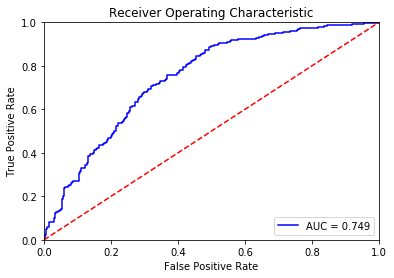

In [327]:
plot_roc_curve(y, y_pred)

In [345]:
def get_model_with_name(name, n_layers=2):
    new_model = AdmissionNet(embedding_dim, hidden_dim, n_layers)
    new_model.to(device)
    new_model.load_state_dict(torch.load(name))
    return new_model

# model_1 = get_model_with_name('./state_dict_lr_001_1024_2.pt')
# model_2 = get_model_with_name('./state_dict_lr_001_1024_2__2.pt')
# model_3 = get_model_with_name('./state_dict_lr_001_1024_2__3.pt')
# model_4 = get_model_with_name('./state_dict_lr_001_1024_2__4.pt')

model_names = ['./state_dict_lr_001_1024_2.pt', 
    './state_dict_lr_001_1024_2__3.pt']
#, './state_dict_lr_001_1024_2__2.pt'

#state_dict_lr_1024_1__4
# model_names = ['./state_dict_lr_1024_1__1.pt', './state_dict_lr_1024_1__2.pt',
#     './state_dict_lr_1024_1__3.pt', './state_dict_lr_1024_1__4.pt']

models = [get_model_with_name(name) for name in model_names]
models.append(get_model_with_name('./state_dict_lr_1024_1__1.pt', n_layers=1))
models.append(get_model_with_name('./state_dict_lr_1024_1__2.pt', n_layers=1))
models.append(get_model_with_name('./state_dict_lr_1024_1__3.pt', n_layers=1))
models.append(get_model_with_name('./state_dict_lr_1024_1__4.pt', n_layers=1))
models.append(get_model_with_name('./state_dict_lr_001_1024_2.pt', n_layers=2))
# models.append(get_model_with_name('./state_dict_lr_001_1024_2__2.pt', n_layers=2))
models.append(get_model_with_name('./state_dict_lr_001_1024_2__3.pt', n_layers=2))
# models.append(get_model_with_name('./state_dict_lr_001_1024_2__4.pt', n_layers=1))

test_losses = []
num_correct = 0
num_total = 0
# h = model.init_hidden(val_batch_size)
hs = [m.init_hidden(val_batch_size) for m in models]

y = np.array([])
y_pred = np.array([])

model.eval()
for inputs, labels in test_loader:
    hs = [tuple([each.data for each in h]) for h in hs]
    inputs, labels = inputs.to(device), labels.to(device)
    
    outputs = []#np.array([[]])
    for i in range(len(hs)):
        output, hs[i] = models[i](inputs, hs[i])
        outputs.append(output.cpu().detach().numpy())
#         outputs = np.concatenate((outputs, output.cpu().detach().numpy()))
    outputs = np.asarray(outputs)
#     print(outputs.shape)
#     print(outputs)
    output = np.mean(outputs, axis=0)
#     print(output.shape)
#     output = outputs[0]
    output_tensor = torch.Tensor(list(output)).to(device)
    
    test_loss = criterion(output_tensor.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output_tensor.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    num_total += pred.size(0)
    
    y = np.concatenate((y, labels.cpu()))
    y_pred = np.concatenate((y_pred, output_tensor.cpu().detach().numpy()))

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/num_total#len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))
print("AUC score: ", roc_auc_score(y, y_pred))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Test loss: 0.591
Test accuracy: 69.088%
AUC score:  0.7505335844318896


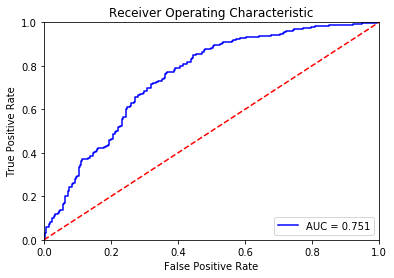

In [346]:
plot_roc_curve(y, y_pred)

In [260]:
Test loss: 0.592
Test accuracy: 69.088%
AUC score:  0.746824173942818

array([0.6013828 , 0.36511523, 0.18351713, 0.699715  ], dtype=float32)

In [238]:
len(y)

592

In [284]:

roc_auc_score(y, y_pred)

0.7510357815442561